In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook #used for loading bar (e.g. to visualise how long an operation is taking)

In [44]:
def sigmoid(z):
    return 1.0/(1+np.exp(-z))


def initialise_parameters(n_a,n_x):
    Wg, bg = np.random.rand(3*n_a,n_a+n_x), np.random.rand(3*n_a, 1)
    Wc, bc = np.random.rand(n_a,n_a+n_x), np.random.rand(n_a, 1)
    Wy, by = np.random.rand(1,n_a), np.random.rand(1, 1)
    a0 = c0 = np.zeros((n_a,1))
    parameters = {"Wg": Wg,"Wc": Wc,"Wy": Wy,"bg": bg, "bc": bc,"by": by, "a0": a0, "c0":c0}
    return parameters
    
def forward_step(a_prev, x, c_prev, parameters):
    n_a = a_prev.shape[0]
    input_concat = np.concatenate((a_prev, x),axis=0)
    IFO_gates = sigmoid(parameters["Wg"].dot(input_concat)+parameters["bg"])
    c_candidate = np.tanh(parameters["Wc"].dot(input_concat)+parameters["bc"])
    c_next = IFO_gates[:n_a]*c_candidate + IFO_gates[n_a:2*n_a]*c_prev
    a_next = IFO_gates[2*n_a:]*np.tanh(c_next)
    cache = (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates)
    return a_next, c_next, cache


def backward_step(dA_next, dC_next,cache,parameters):
    (a_next, c_next, input_concat, c_prev, c_candidate,IFO_gates) = cache
    n_a, m = a_next.shape
    
    dC_next += dA_next* (IFO_gates[2*n_a:]*(1-np.tanh(c_next)**2))
    
    dC_prev = dC_next * IFO_gates[n_a:2*n_a]
    dC_candidate =  dC_next * IFO_gates[:n_a]
    
    dIFO_gates = np.zeros_like(IFO_gates)
    dIFO_gates[:n_a] = dC_next * c_candidate 
    dIFO_gates[n_a:2*n_a]= dC_next * c_prev
    dIFO_gates[2*n_a:] = dA_next * np.tanh(c_next)

    dZ_gate =  dIFO_gates* (IFO_gates*(1-IFO_gates))   
    dA_prev =  (parameters["Wg"].T).dot(dZ_gate)[:n_a]
    dWg = (1/m)*dZ_gate.dot(input_concat.T)
    dbg = (1/m)*np.sum(dZ_gate,axis=1, keepdims=True)
    
    dZ_c = dC_candidate * (1-c_candidate**2)
    dA_prev +=  (parameters["Wc"].T).dot(dZ_c)[:n_a]
    dWc = (1/m)*dZ_c.dot(input_concat.T)
    dbc = (1/m)*np.sum(dZ_c,axis=1, keepdims=True)  
    
    return dA_prev, dC_prev, dWg, dbg, dWc, dbc



In [100]:
def forward_prop(X, parameters):
    m, _, Tx = X.shape
    a_prev = np.repeat(parameters["a0"],m, axis=1)
    c_prev = np.repeat(parameters["c0"],m, axis=1)
    caches= []
    for t in range(Tx):
        xt = np.squeeze(X[:,:,t]).T #so 2D matrix n_x, m
        a_prev, c_prev, cache = forward_step(a_prev,xt , c_prev, parameters)
        caches.append(cache)
    y_pred = sigmoid(parameters["Wy"].dot(a_prev)+parameters["by"])
    return y_pred, caches


def backprop(X,y, y_pred, parameters, caches,lambd):
    m, _, Tx = X.shape
    grads = {}
    
    
    dZ_pred = (y_pred-y) 
    dA =  (parameters["Wy"].T).dot(dZ_pred)
    grads["dWy"] = (1/m)*dZ_pred.dot(caches[Tx-1][0].T) #this is A<t>
    grads["dby"] = (1/m)*np.sum(dZ_pred,axis=1, keepdims=True)
    
    dC = np.zeros_like(dA)
    
    grads["dWg"] = np.zeros_like(parameters["Wg"])
    grads["dbg"] = np.zeros_like(parameters["bg"])
    grads["dWc"] = np.zeros_like(parameters["Wc"])
    grads["dbc"] = np.zeros_like(parameters["bc"])
    
    
    for t in reversed(range(Tx)):
        (dA, dC, dWg, dbg, dWc, dbc) = backward_step(dA, dC, caches[t],parameters)
        grads["dWg"] += dWg
        grads["dbg"] += dbg
        grads["dWc"] += dWc
        grads["dbc"] += dbc
    
    grads["da0"] = dA
    grads["dc0"] = dC
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]+= (lambd/m)*parameters[key[1:]] 
    
    return grads


In [101]:
def loss_function(y_pred,y, parameters, lambd):
    m = y.shape[0]
    cost = (-1/m)*np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W" in key:
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost


In [102]:
def accuracy(y_pred,y):
    preds = np.rint(y_pred) #round to int
    return np.mean(np.equal(preds,y).astype(int))

In [103]:
%matplotlib notebook
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs,batch_size,lambd,learning_rate,num_hidden_units=512, parameters = None ):
    train_costs = []
    train_evals = []
    dev_evals = []
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    
    ax1.set_xlabel('Number of iterations')
    ax1.set_ylabel('Error')
    ax1.set_title('Training Set Error')
    
    ax2.set_xlabel('Number of iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Set Accuracy')
    
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Dev Set Accuracy')

    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    if parameters==None:
        parameters = initialise_parameters(num_hidden_units, X[0].shape[1])
        
    for epoch in tqdm_notebook(range (num_epochs), total=num_epochs,desc="Number of Epochs"):
        #cycle through the entire training set in batches
        for i in tqdm_notebook(range(len(X_train)), total = len(X_train), desc = "Minibatch number"):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i]
            Y_train_minibatch = Y_train[i]
            
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, caches = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, caches,lambd)
            
            
            #update the parameters using gradient descent
            for param in parameters.keys():
                parameters[param] = parameters[param] - learning_rate*minibatch_grads["d"+param]
            
            #visualise error
            train_costs.append(minibatch_cost)
            ax1.plot(train_costs)
            fig.canvas.draw()
            
            
            train_eval_metric = accuracy(y_pred,Y_train_minibatch)
            train_evals.append(train_eval_metric)
            ax2.plot(train_evals)
            fig.canvas.draw()
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%100 == 0):
                print("Training set error: "+ str(minibatch_cost))
                print("Training set accuracy: "+ str(train_eval_metric))
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
                ax3.plot(dev_evals)
                fig.canvas.draw()
    print("Training complete!")
    #return the trained parameters 
    return parameters

In [104]:
b = initialise_parameters(4,5)

a_next, c_next, cache = forward_step(np.random.rand(4,10), np.random.rand(5,10), np.random.rand(4,10), b)

(dA_prev, dC_prev, dWg, dbg, dWc, dbc) = backward_step(a_next,c_next,cache,b)

(4, 10)
(5, 10)


In [105]:
X = []
Y = []
for i in range(10,20):
    X.append(np.random.rand(5,23,i))
    Y.append(np.ones((1,5)))
X2 = np.random.rand(10,23,25)
Y2 = np.ones((1,10))


<IPython.core.display.Javascript object>


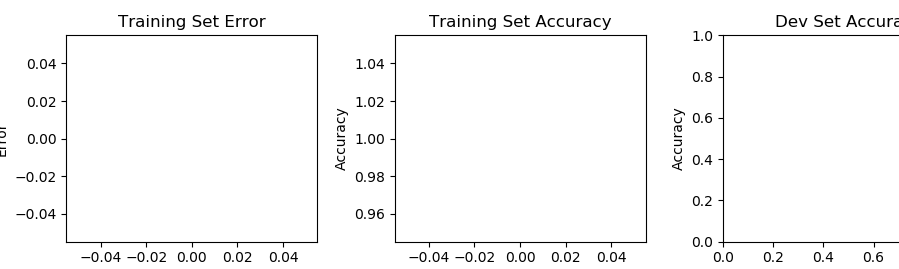

(512, 5)
(23, 5)
(512, 5)
(23, 5)
(512, 5)
(23, 5)
(512, 5)
(23, 5)
(512, 5)
(23, 5)
(512, 5)
(23, 5)
(512, 5)
(23, 5)
(512, 5)
(23, 5)
(512, 5)
(23, 5)
(512, 5)
(23, 5)
Training set error: nan
Training set accuracy: 1.0
(512, 50)
(23, 10)


/home/mukulrathi/miniconda3/envs/testenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mukulrathi/miniconda3/envs/testenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [106]:
train_model(X, Y, X2, Y2,num_epochs=1,batch_size=8,lambd=10,learning_rate=0.1)